**data & label 資料位置**

- https://drive.google.com/u/1/uc?id=1-3Qw41-frYJGfp5slOGbW6hmn8mP4gL4&export=download
- https://drive.google.com/u/1/uc?id=1-0xN6p5mcc2iC7R6dcjmg370RullIWHF&export=download

In [1]:
#@title Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#@title 從Google Drive 匯入 data & label 資料
train_data_path = '/content/drive/MyDrive/aidataset/train_data_25_c40.npy' #@param {type:"string"}
train_label_path =  '/content/drive/MyDrive/aidataset/train_label_25_c40.npy' #@param {type:"string"}
cmd  = f'cp {train_data_path} ./train_data.npy'
! $cmd
cmd  = f'cp {train_label_path} ./train_label.npy'
! $cmd

In [3]:
#@title 載入 data & label 資料
import numpy as np
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator


train_data = np.load("train_data.npy")
train_label = np.load("train_label.npy")

print("Dataset Loaded...")

# Train and validation split
trainX, valX, trainY, valY = train_test_split(
    train_data, train_label, test_size=0.1, shuffle=False
)
print(trainX.shape, valX.shape, trainY.shape, valY.shape)

Dataset Loaded...
(3712, 160, 160, 3) (413, 160, 160, 3) (3712, 2) (413, 2)


In [4]:
#@title 選擇模型
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.callbacks import CSVLogger
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.applications.nasnet import NASNetLarge
from matplotlib import pyplot as plt
from tensorflow.keras import backend as K
import numpy as np
import time
import argparse
from os.path import exists
from os import makedirs
import tensorflow.compat.v1.keras.backend as K
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

def cnn_model(model_name, img_size):
    """
    Model definition using Xception net architecture
    """
    input_size = (img_size, img_size, 3)
    if model_name == "xception":
        baseModel = Xception(
            weights="imagenet",
            include_top=False,
            input_shape=(img_size, img_size, 3)
        )
    elif model_name == "iv3":
        baseModel = InceptionV3(
            weights="imagenet",
            include_top=False,
            input_shape=(img_size, img_size, 3)
        )
    elif model_name == "irv2":
        baseModel = InceptionResNetV2(
            weights="imagenet",
            include_top=False,
            input_shape=(img_size, img_size, 3)
        )
    elif model_name == "resnet":
        baseModel = ResNet50(
            weights="imagenet",
            include_top=False,
            input_shape=(img_size, img_size, 3)
        )


    headModel = baseModel.output
    headModel = GlobalAveragePooling2D()(headModel)
    headModel = Dense(512, activation="relu", kernel_initializer="he_uniform")(
        headModel
    )
    headModel = Dropout(0.4)(headModel)
    headModel = Dropout(0.5)(headModel)
    predictions = Dense(
        2,
        activation="softmax",
        kernel_initializer="he_uniform")(
        headModel
    )
    model = Model(inputs=baseModel.input, outputs=predictions)

    for layer in baseModel.layers:
        layer.trainable = True

    optimizer = Nadam(
        learning_rate=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-08, schedule_decay=0.004
    )
    model.compile(
        loss="categorical_crossentropy",
        optimizer=optimizer,
        metrics=["accuracy"]
    )
    return model



# Train nad validation image data generator
trainAug = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest",
)

valAug = ImageDataGenerator(rescale=1.0 / 255.0)
model_choice = 'xception' #@param ["xception", "iv3", "irv2", "resnet"]
model = cnn_model(model_choice, 160)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
83697664/83683744 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 79, 79, 32)   864         ['input_1[0][0]']                
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 79, 79, 32)  128         ['block1_conv1[0][0]']           
 ation)                                                 

In [6]:
#@title 模型訓練
epochs_num =  10 #@param {type:"integer"}
H = model.fit(
    trainAug.flow(trainX, trainY, batch_size=32),
    steps_per_epoch=len(trainX) // 32,
    validation_data=valAug.flow(valX, valY),
    validation_steps=len(valX) // 32,
    epochs=epochs_num,
)

116/116 [==============================] - 46s 396ms/step - batch: 57.5000 - size: 32.0000 - loss: 0.0884 - accuracy: 0.9677 - val_loss: 22.5658 - val_accuracy: 0.0391


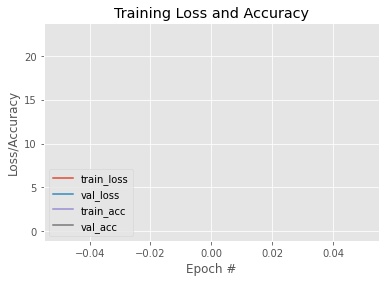

In [9]:
#@title 繪製訓練損失與準確率變化
plt.style.use("ggplot")
plt.figure()
N = len(H.history["loss"])
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
